# Part 1: Download data and set directories

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Download data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# List path contents
!ls $PATH

68608000/68606236 [==============================] - 0s 0us/step
train  validation  vectorize.py


In [ ]:
# Define paths to training and validation images
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

# Specify them by class
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with training dog pictures
val_cats_dir = os.path.join(val_dir, 'cats')      # directory with validation cat pictures
val_dogs_dir = os.path.join(val_dir, 'dogs')      # directory with validation dog pictures

# Print example
print(train_cats_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [ ]:
# Count how many of them are there
n_cats_train = len(os.listdir(train_cats_dir))
n_dogs_train = len(os.listdir(train_dogs_dir))

n_cats_val = len(os.listdir(val_cats_dir))
n_dogs_val = len(os.listdir(val_dogs_dir))

n_total_train = n_cats_train + n_dogs_train
n_total_val = n_cats_val + n_dogs_val

# Print some info
print('total training cat images:', n_cats_train)
print('total training dog images:', n_dogs_train)

print('total validation cat images:', n_cats_val)
print('total validation dog images:', n_dogs_val)
print("--")
print("Total training images:", n_total_train)
print("Total validation images:", n_total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Part 2: Define batch-generator process

In [ ]:
# Define some constants
batch_size = 16
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
# Define generator objects for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

ImageDataGenerator class has three methods flow(), flow_from_directory() and flow_from_dataframe() to read the images from a big numpy array and folders containing images.

+ The directory must be set to the path where your ‘n’ classes of folders are present.
+ The target_size is the size of your input images, every image will be resized to this size.
+ batch_size: No. of images to be yielded from the generator per batch.
+ class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”.
+ shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False. 

In [ ]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(16, 128, 128, 3)
0.0
1.0
(16,)


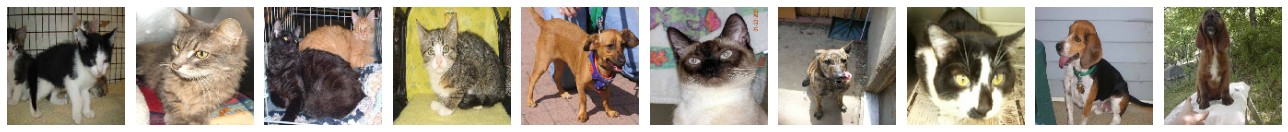

[0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.]


In [ ]:
# This 'next' function returns a batch (length=16 in this example) from the dataset
sample_x, sample_y = next(train_generator) #return the next item from the iterator
print(sample_x.shape)
print(sample_x.min())  #between 0 and 1
print(sample_x.max())
print(sample_y.shape)

# Show a few of them
fig, axes = plt.subplots(1, 10, figsize=(18, 5))
axes = axes.flatten()
for img, ax in zip(sample_x[:10], axes):
  ax.imshow(img)
  ax.axis('off')
plt.tight_layout()
plt.show()

print(sample_y[:20])

# Part 3: Create CNN model and train it

In [ ]:
# Create a CNN
CNN = Sequential([
    BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0

In [ ]:
# Compile: Define training parameters
CNN.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [ ]:
# Train model
n_epochs = 20
history = CNN.fit(
    train_generator,
    steps_per_epoch=n_total_train//batch_size,
    epochs=n_epochs,
    validation_data=val_generator,
    validation_steps=n_total_val//batch_size
)

Epoch 1/20
125/125 [==============================] - 8s 63ms/step - loss: 0.2876 - accuracy: 0.5595 - val_loss: 0.2394 - val_accuracy: 0.5544
Epoch 2/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2055 - accuracy: 0.6938 - val_loss: 0.2261 - val_accuracy: 0.6341
Epoch 3/20
125/125 [==============================] - 8s 61ms/step - loss: 0.1571 - accuracy: 0.7791 - val_loss: 0.2091 - val_accuracy: 0.6714
Epoch 4/20
125/125 [==============================] - 8s 61ms/step - loss: 0.1331 - accuracy: 0.8124 - val_loss: 0.2213 - val_accuracy: 0.6482
Epoch 5/20
125/125 [==============================] - 8s 61ms/step - loss: 0.0980 - accuracy: 0.8771 - val_loss: 0.2121 - val_accuracy: 0.6714
Epoch 6/20
125/125 [==============================] - 8s 62ms/step - loss: 0.0925 - accuracy: 0.8705 - val_loss: 0.2063 - val_accuracy: 0.6845
Epoch 7/20
125/125 [==============================] - 8s 62ms/step - loss: 0.0637 - accuracy: 0.9263 - val_loss: 0.2141 - val_accuracy: 0.6865

# Part 4: Create CNN model and proof with different architectures

In [ ]:
def get_model(n):
  """Function to get the model arquitecture to try the same model but with different arquitecture
    """
  models = n
  for model in range(models):
    if model == 1:
      #Model 1 
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='relu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='relu'),
          Dense(256, activation='relu'),
          Dense(128, activation='relu'),
          Dense(64, activation='relu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])

    elif model == 2:
      #Model 2
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='elu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='elu'),
          Dense(256, activation='elu'),
          Dense(128, activation='elu'),
          Dense(64, activation='elu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])

    elif model == 3:
      #Model 3
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(16, 3, activation='relu'),
          Conv2D(32, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='relu'),
          Conv2D(32, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='relu'),
          Conv2D(64, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='relu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='relu'),
          Dense(256, activation='relu'),
          Dense(128, activation='relu'),
          Dense(64, activation='relu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

    elif model == 4:

      #Model 4
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='elu'),
          Conv2D(32, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='elu'),
          Conv2D(64, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='elu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='elu'),
          Dense(256, activation='elu'),
          Dense(128, activation='elu'),
          Dense(64, activation='elu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

    if model == 5:
      #Model 5 

      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='relu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='relu'),
          Dense(256, activation='relu'),
          Dense(128, activation='relu'),
          Dense(64, activation='relu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])

    elif model == 6:
      #Model 6
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='elu'),
          Conv2D(16, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='elu'),
          Conv2D(64, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='elu'),
          Conv2D(256, 3, activation='relu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='elu'),
          Dense(256, activation='elu'),
          Dense(128, activation='elu'),
          Dense(64, activation='elu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])


      CNN.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])

    elif model == 7:
      #Model 7
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='relu'),
          Conv2D(128, 3, activation='relu'),
          Conv2D(256, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='relu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='relu'),
          Dense(256, activation='relu'),
          Dense(128, activation='relu'),
          Dense(64, activation='relu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])

    else :

      #Model 8
      CNN = Sequential([
          BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
          Conv2D(32, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(64, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(128, 3, activation='elu'),
          Conv2D(64, 3, activation='relu'),
          Conv2D(256, 3, activation='relu'),
          MaxPooling2D(),
          Conv2D(256, 3, activation='elu'),
          MaxPooling2D(),
          Conv2D(512, 3, padding='same', activation='elu'),
          MaxPooling2D(),
          
          Flatten(),
          BatchNormalization(),
          Dense(512, activation='elu'),
          Dense(256, activation='elu'),
          Dense(128, activation='elu'),
          Dense(64, activation='elu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

      CNN.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])

    return CNN

In [ ]:
def eval_model(val_generator, train_generator):

  bs = [64, 64, 64, 64, 64, 64, 32, 32]
  models = [1,2,3,4,5,6,7,8]
  n_epochs = 50
  loss_train = []
  loss_validation = []
  accuracy_train = []
  accuracy_validation = []
  model = []

  for md,batch_s in zip(models,bs):
    model.append(md)
    #Train model
    CNN = get_model(md)
    history = CNN.fit(
        train_generator,
        steps_per_epoch=n_total_train//batch_s,
        epochs=n_epochs,
        validation_data=val_generator,
        validation_steps=n_total_val//batch_s
    )
    # Compute test loss 
    loss_train.append(CNN.history.history['loss'][-1])
    loss_validation.append(CNN.history.history['val_loss'][-1])
    accuracy_train.append(CNN.history.history['accuracy'][-1])
    accuracy_validation.append(CNN.history.history['val_accuracy'][-1])

    # Reset session
    tf.keras.backend.clear_session()

  table={'model':model, 'loss_train':loss_train,'loss_validation':loss_validation,'accuracy_train':accuracy_train,'accuracy_validation':accuracy_validation}       
  results=pd.DataFrame(table)
    
  return results

In [ ]:
evaluations = eval_model(val_generator, train_generator)

In [ ]:
import pickle

filename = 'models.pkl'
pickle.dump(evaluations, open(filename, 'wb'))

In [ ]:
pd.read_pickle('models.pkl')

,model,loss_train,loss_validation,accuracy_train,accuracy_validation
0,1,0.008983,0.218400,0.993952,0.704167
1,2,0.015988,0.181680,0.985887,0.741667
2,3,0.020555,0.217878,0.977823,0.720833
3,4,0.018060,0.216444,0.981855,0.708333
4,5,0.011254,0.203789,0.989919,0.729167
5,6,0.010281,0.241248,0.997984,0.691667
6,7,0.005083,0.192932,0.994960,0.741935
7,8,0.005500,0.209755,0.993952,0.735887


Obs. En esta 1ra corrida el modelo que tuvo mayor accuracy en validation fue el # 7 y el que tuvo menor pérdida en validación fue el #2

In [ ]:
evaluations_2 = eval_model(val_generator, train_generator)

In [ ]:
filename = 'models_2.pkl'
pickle.dump(evaluations_2, open(filename, 'wb'))
pd.read_pickle('models_2.pkl')

,model,loss_train,loss_validation,accuracy_train,accuracy_validation
0,1,0.015465,0.156207,0.985887,0.783333
1,2,0.012537,0.180481,0.991935,0.762500
2,3,0.015004,0.197542,0.979839,0.729167
3,4,0.019502,0.209736,0.977823,0.700000
4,5,0.017121,0.189534,0.985887,0.733333
5,6,0.021776,0.196626,0.973790,0.733333
6,7,0.005924,0.247405,0.991935,0.671371
7,8,0.005175,0.246235,0.994960,0.697581


Obs. En la 2da corrida el modelo que tuvo mayor accuracy en validation y menos pérdida en validaciñon fue el #1

In [ ]:
evaluations_3 = eval_model(val_generator, train_generator)

In [ ]:
filename = 'models_3.pkl'
pickle.dump(evaluations_3, open(filename, 'wb'))
pd.read_pickle('models_3.pkl')

,model,loss_train,loss_validation,accuracy_train,accuracy_validation
0,1,0.016546,0.176896,0.987903,0.754167
1,2,0.018991,0.212414,0.987903,0.708333
2,3,0.019262,0.242158,0.981855,0.679167
3,4,0.018706,0.223620,0.981855,0.700000
4,5,0.017097,0.218478,0.977823,0.683333
5,6,0.013847,0.213165,0.985887,0.695833
6,7,0.002959,0.212363,0.997984,0.735887
7,8,0.006272,0.234467,0.993952,0.715726


Obs. Se obtuvo que el modelo que tuvo mayor accuracy en validation y menos pérdida en validación fue el #1

In [ ]:
#Prueba para guardar la corrida como Pickle
evaluations_4 = eval_model(val_generator, train_generator)

In [ ]:
filename = 'models_4.pkl'
pickle.dump(evaluations_4, open(filename, 'wb'))
pd.read_pickle('models_4.pkl')

,model,loss_train,loss_validation,accuracy_train,accuracy_validation
0,1,0.018818,0.209093,0.979839,0.716667
1,2,0.022473,0.326570,0.971774,0.604167
2,3,0.014809,0.223742,0.985887,0.695833
3,4,0.015986,0.199679,0.985887,0.741667
4,5,0.011569,0.194760,0.993952,0.700000
5,6,0.012232,0.171262,0.987903,0.762500
6,7,0.005304,0.208894,0.993952,0.727823
7,8,0.007527,0.258050,0.988911,0.685484


Obs. El modelo que tuvo mayor accuracy en validation y menos pérdida en validaciñon fue el #6

In [ ]:
evaluations_5 = eval_model(val_generator, train_generator)

In [ ]:
filename = 'models_5.pkl'
pickle.dump(evaluations_5, open(filename, 'wb'))
pd.read_pickle('models_5.pkl')

,model,loss_train,loss_validation,accuracy_train,accuracy_validation
0,1,0.012755,0.205254,0.985887,0.720833
1,2,0.018048,0.233871,0.981855,0.716667
2,3,0.023669,0.213326,0.973790,0.691667
3,4,0.019069,0.205971,0.975806,0.700000
4,5,0.010930,0.200795,0.991935,0.729167
5,6,0.015100,0.262233,0.983871,0.654167
6,7,0.004145,0.211518,0.996976,0.729839
7,8,0.002543,0.214870,0.998992,0.727823


Obs. El modelo que tuvo mayor accuracy en validation fue el modelo #7, y el que tuvo menor pérdida en validación fue el #5 

# Mean performance for each model

In [ ]:
mod1 = pd.read_pickle('models.pkl')
mod2 = pd.read_pickle('models_2.pkl')
mod3 = pd.read_pickle('models_3.pkl')
mod4 = pd.read_pickle('models_4.pkl')
mod5 = pd.read_pickle('models_5.pkl')

In [ ]:
# Append all models
models = mod1.append([mod2, mod3, mod4, mod5],ignore_index=True )

In [ ]:
# Mean per model
models.groupby('model').mean()

,loss_train,loss_validation,accuracy_train,accuracy_validation
model,,,,
1,0.014513,0.193170,0.986694,0.735833
2,0.017608,0.227003,0.983871,0.706667
3,0.018660,0.218929,0.979839,0.703333
4,0.018265,0.211090,0.980645,0.710000
5,0.013594,0.201471,0.987903,0.715000
6,0.014647,0.216907,0.985887,0.707500
7,0.004683,0.214622,0.995161,0.721371
8,0.005403,0.232676,0.994153,0.712500


Obs. Se obtiene que en promedio el mejor modelo es el # 1 en cuanto *accuracy* y en cuanto a pérdida (loss validation)

# Part 4: Compile and train the winner arquitecture

In [ ]:
# Define some constants
batch_size = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#Model 1 
CNN = Sequential([
BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          
Conv2D(32, 3, activation='relu'),
MaxPooling2D(),
Conv2D(64, 3, activation='relu'),
MaxPooling2D(),
Conv2D(128, 3, activation='relu'),
MaxPooling2D(),
Conv2D(256, 3, activation='relu'),
MaxPooling2D(),
Conv2D(512, 3, padding='same', activation='relu'),
MaxPooling2D(),
          
Flatten(),
BatchNormalization(),
Dense(512, activation='relu'),
Dense(256, activation='relu'),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dropout(0.3),
Dense(1, activation='sigmoid')
      ])

CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0

In [ ]:
CNN.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])

In [ ]:
# Train model
n_epochs = 50
history = CNN.fit(
    train_generator,
    steps_per_epoch=n_total_train//batch_size,
    epochs=n_epochs,
    validation_data=val_generator,
    validation_steps=n_total_val//batch_size
)

Epoch 1/50
31/31 [==============================] - 9s 264ms/step - loss: 0.2517 - accuracy: 0.5394 - val_loss: 0.2497 - val_accuracy: 0.5010
Epoch 2/50
31/31 [==============================] - 8s 257ms/step - loss: 0.2297 - accuracy: 0.6188 - val_loss: 0.2490 - val_accuracy: 0.5594
Epoch 3/50
31/31 [==============================] - 8s 259ms/step - loss: 0.2167 - accuracy: 0.6934 - val_loss: 0.2486 - val_accuracy: 0.6187
Epoch 4/50
31/31 [==============================] - 8s 253ms/step - loss: 0.2086 - accuracy: 0.6912 - val_loss: 0.2478 - val_accuracy: 0.5760
Epoch 5/50
31/31 [==============================] - 8s 253ms/step - loss: 0.1954 - accuracy: 0.7457 - val_loss: 0.2468 - val_accuracy: 0.5802
Epoch 6/50
31/31 [==============================] - 8s 255ms/step - loss: 0.1836 - accuracy: 0.7797 - val_loss: 0.2452 - val_accuracy: 0.5917
Epoch 7/50
31/31 [==============================] - 8s 254ms/step - loss: 0.1711 - accuracy: 0.7778 - val_loss: 0.2433 - val_accuracy: 0.6083
Epoch 

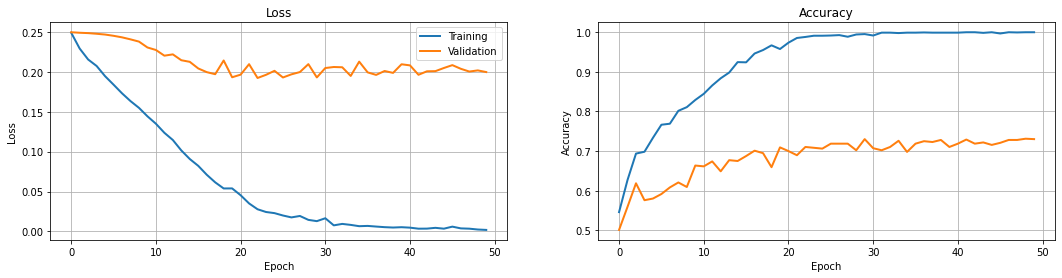

In [ ]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Reset session
tf.keras.backend.clear_session()

# Part 4: A new type of CNN

In [3]:
# Importa los dígitos MNIST
# == Q2 ==
# Revisa esta y las tres celdas siguientes.
# Explica por qué crees que, al importar las imágenes, las asignamos a una
# variable llamada 'y' (en vez de 'x' como lo hicimos en la tarea anterior).
from tensorflow.keras.datasets import mnist
(y_train, _), (y_test, _) = mnist.load_data() # puedes revisar la documentación
y_train = y_train / 255.
y_test  = y_test  / 255.
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
y_test  = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

print("Shapes")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes
y_train: (60000, 28, 28, 1)
y_test: (10000, 28, 28, 1)


In [4]:
# == Q3 ==
# Aquí defino una función. ¿Puedes explica qué es lo que hace?
from skimage.transform import resize

def noisy_resize(IMG):
  img = resize(IMG.copy(), (7, 7))
  for row in range(7):
    for col in range(7):
      thresh = np.random.rand()
      if thresh > 0.9:
        img[row, col] = np.abs(img[row, col] - 1)
  return img

In [5]:
# Ahora sí genero x (señales de entrada)
x_train = np.array([noisy_resize(IMG) for IMG in y_train])
x_test  = np.array([noisy_resize(IMG) for IMG in y_test ])

print("Shapes")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

Shapes
x_train: (60000, 7, 7, 1)
x_test: (10000, 7, 7, 1)


In [6]:
# Create a CNN
CNN = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(1, 3, padding='same', activation='sigmoid'),
])

CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9

In [7]:
# Compile: Define training parameters
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = CNN.fit(x=x_train, y=y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/50
844/844 [==============================] - 11s 5ms/step - loss: 0.2097 - accuracy: 0.7977 - val_loss: 0.1067 - val_accuracy: 0.8105
Epoch 2/50
844/844 [==============================] - 4s 5ms/step - loss: 0.1029 - accuracy: 0.8110 - val_loss: 0.0983 - val_accuracy: 0.8122
Epoch 3/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0968 - accuracy: 0.8118 - val_loss: 0.0951 - val_accuracy: 0.8121
Epoch 4/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0934 - accuracy: 0.8129 - val_loss: 0.0933 - val_accuracy: 0.8121
Epoch 5/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0912 - accuracy: 0.8128 - val_loss: 0.0904 - val_accuracy: 0.8132
Epoch 6/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0894 - accuracy: 0.8130 - val_loss: 0.0897 - val_accuracy: 0.8130
Epoch 7/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0881 - accuracy: 0.8131 - val_loss: 0.0882 - val_accuracy: 0.8138
Epoch

In [ ]:
# == Q4 ==
# ¿Qué problema está resolviendo esta red?

# == Q5 ==
# ¿Puedes mejorar el modelo para aumentar la exactitud de validación a más de 0.95?
# Reporta el modelo resultante.